In [2]:
import rioxarray as rix
import os
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
import numpy as np
from shapely import geometry
import math
import pandas as pd
import glob
import altair as alt

# Open SCA rasters from 2023

In [3]:
files = sorted(glob.glob('./SCA/*2023*.tif'))

In [4]:
files

['./SCA/2023-05-09_strip_6495899_composite_file_format_SCA.tif',
 './SCA/2023-05-10_strip_6497912_composite_file_format_SCA.tif',
 './SCA/2023-05-13_strip_6505736_composite_file_format_SCA.tif',
 './SCA/2023-05-15_strip_6510381_composite_file_format_SCA.tif',
 './SCA/2023-05-16_strip_6512704_composite_file_format_SCA.tif',
 './SCA/2023-05-23_strip_6528815_composite_file_format_SCA.tif']

In [5]:
srcs = [rix.open_rasterio(
    fn,
    chunks='auto',
    masked=True
) for fn in files]

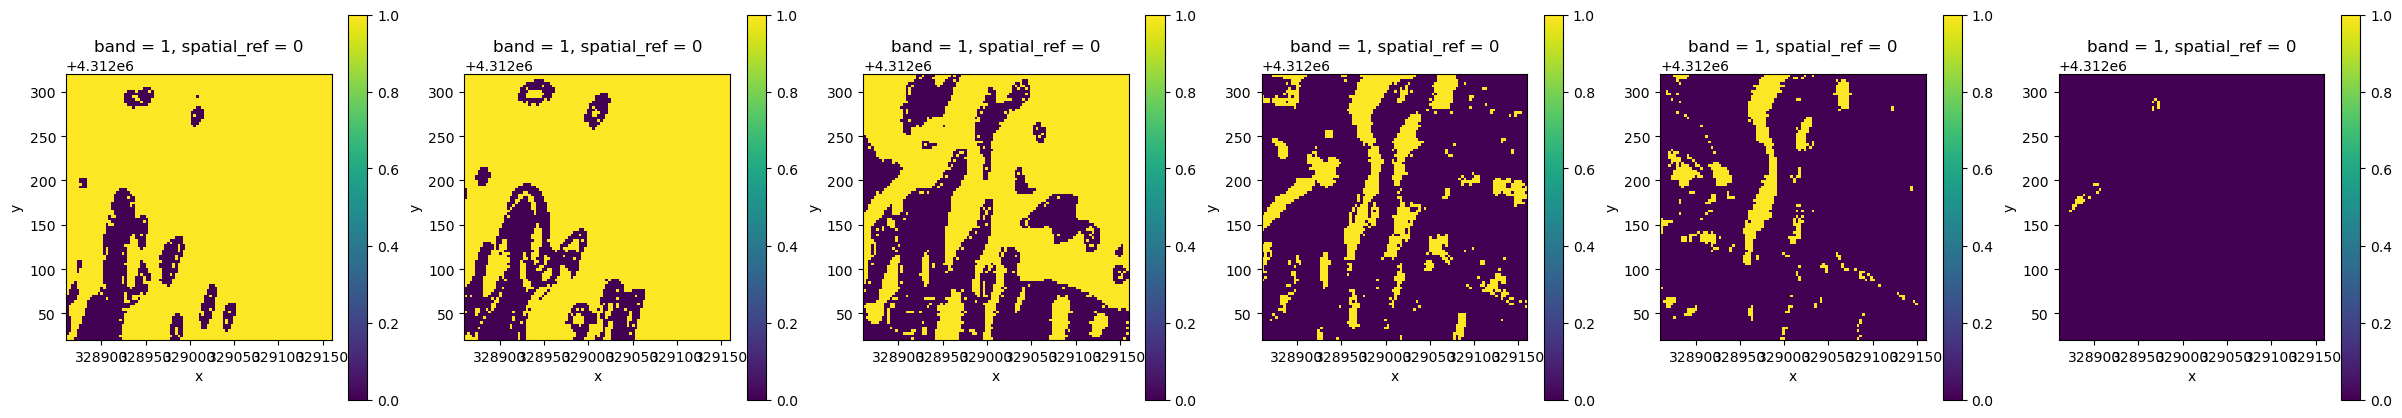

In [6]:
import matplotlib.colors as mcolors
fig, axes = plt.subplots(1,len(srcs),figsize=(5*len(srcs), 5))
for ax,src in zip(axes, srcs):
    src.plot(ax=ax)
    ax.set_aspect('equal')

# Extract data along one line

In [7]:
def calculate_endpoint(x, y, bearing, distance):
    """ Given a starting point, compass bearing, and distance, get an end point
    """    
    # Convert bearing to radians
    bearing_rad = - np.deg2rad(bearing) - np.deg2rad(90)
    # Calculate the new coordinates
    end_x = x - distance * math.cos(bearing_rad)
    end_y = y - distance * math.sin(bearing_rad)
    return end_x, end_y

def create_linestring_from_points(start_x, start_y, end_x, end_y, resolution):
    """ Given two end points, create a LineString with the provided resolution
    """    
    line = geometry.LineString([(start_x, start_y), (end_x, end_y)]) # Create the LineString
    line_length = line.length
    # Generate points at intervals of given reoslution
    num_points = int(line_length / resolution) + 1 
    interpolated_points = [line.interpolate(distance) for distance in np.linspace(0, line_length, num_points)]
    high_res_line = geometry.LineString(interpolated_points) # Create a new LineString with the interpolated points
    return high_res_line

def sample_along_line(line, raster):
    """ Sample from a raster each point in a LineString
    """    
    points = list(line.coords)
    # Initialize a list to store sampled values
    sampled_values = []
    distances = []

    first_point = points[0]
    # Loop through each point and sample the value in irband_lowres
    for point in points:
        x, y = point  # Extract x and y coordinates
        value = raster.sel(x=x, y=y, method="nearest").values[0]  # Sample value
        sampled_values.append(value)
        distance = np.sqrt((x - first_point[0])**2 + (y - first_point[1])**2)
        distances.append(distance)

    # Convert sampled values to a numpy array (optional)
    sampled_values = np.array(sampled_values)

    sample_df = pd.DataFrame({
        'temp': sampled_values,
        'distance': distances,
    }).set_index('distance')
    
    return sample_df

def calculate_temp_segment_lengths(df, root = 0):
    """ Given a dataframe returned from sample_along_line (defined above), 
    calculate the number of and length of contiguous segments with values 
    less than the provided root value
    """    
    # Step 1: Identify segments where temp < root
    df['below_zero'] = df['temp'] < root

    # Step 2: Group consecutive indices where temp < root
    df['segment'] = (df['below_zero'] != df['below_zero'].shift()).cumsum()

    # Step 3: Calculate the length of each segment where temp < root
    segment_lengths = (
        df[df['below_zero']]
        .groupby('segment')
        .apply(lambda group: group.index[-1] - group.index[0], include_groups=False)
    )
    return segment_lengths

In [8]:
start_x = src.x.min().item()
start_y = src.y.max().item()
end_x, end_y = calculate_endpoint(start_x, start_y, 135, 420)

high_res_line = create_linestring_from_points(start_x, start_y, end_x, end_y, resolution=0.1)

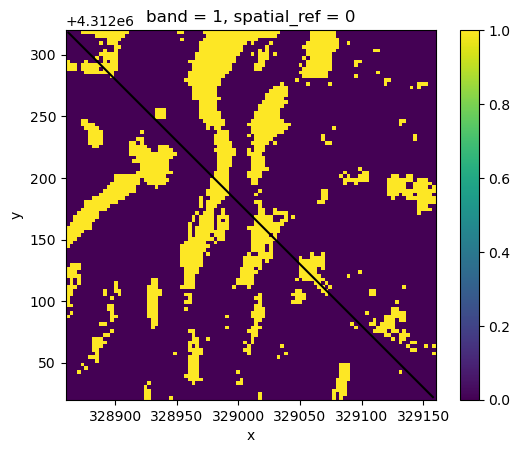

In [9]:
fig, ax = plt.subplots()
gpd.GeoDataFrame(geometry=[high_res_line]).plot(color='black', ax=ax)
srcs[3].plot()

Invert it, to make the path-finding algorithm work

In [10]:
for i in range(len(srcs)):
    src = srcs[i]
    srcs[i] = src.copy(data = (~src.values.astype(bool)).astype(int))

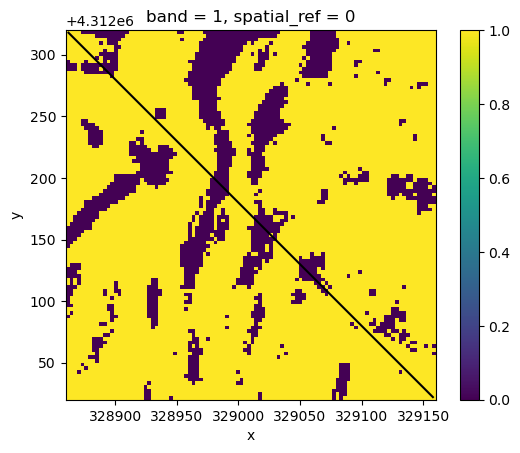

In [11]:
fig, ax = plt.subplots()
gpd.GeoDataFrame(geometry=[high_res_line]).plot(color='black', ax=ax)
srcs[3].plot()

In [12]:
sample_df1  = sample_along_line(high_res_line, srcs[3])
sample_df2  = sample_along_line(high_res_line, srcs[4])

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

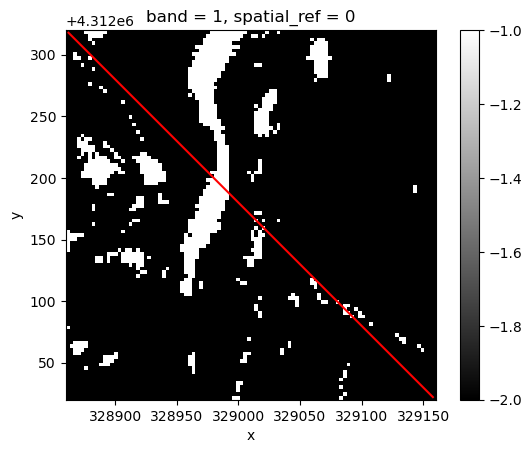

In [17]:
fig, ax = plt.subplots()
(~srcs[4]).plot(cmap='grey', ax=ax)
gpd.GeoDataFrame(geometry=[high_res_line]).plot(color='red', ax=ax)

[Text(0, 0, 'Snow'), Text(0, 1, 'Not Snow')]

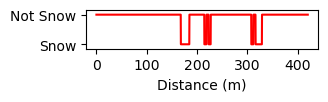

In [18]:
sample_df2['temp'].plot(figsize=(3,0.5),color='red')
plt.xlabel(r'Distance (m)')
plt.yticks([0,1])
plt.ylim(-0.15,1.15)
plt.gca().set_yticklabels(['Snow','Not Snow'])

# Extract data along many lines

Create many lines

In [23]:
start_x = src.x.min().item()
start_y = src.y.max().item()

start_points = []
start_points = start_points + [geometry.Point(start_x, start_y)]

for adj in np.linspace(0, 250, 52):
    print(adj)
    start_points = start_points + [
        geometry.Point(start_x, start_y + adj),
        geometry.Point(start_x, start_y - adj)
    ]

0.0
4.901960784313726
9.803921568627452
14.705882352941178
19.607843137254903
24.50980392156863
29.411764705882355
34.31372549019608
39.21568627450981
44.117647058823536
49.01960784313726
53.92156862745098
58.82352941176471
63.72549019607844
68.62745098039215
73.52941176470588
78.43137254901961
83.33333333333334
88.23529411764707
93.13725490196079
98.03921568627452
102.94117647058825
107.84313725490196
112.74509803921569
117.64705882352942
122.54901960784315
127.45098039215688
132.3529411764706
137.2549019607843
142.15686274509804
147.05882352941177
151.9607843137255
156.86274509803923
161.76470588235296
166.66666666666669
171.56862745098042
176.47058823529414
181.37254901960785
186.27450980392157
191.1764705882353
196.07843137254903
200.98039215686276
205.8823529411765
210.78431372549022
215.68627450980392
220.58823529411765
225.49019607843138
230.3921568627451
235.29411764705884
240.19607843137257
245.0980392156863
250.0


In [24]:
len(start_points)

105

In [25]:
end_points = [geometry.Point(calculate_endpoint(pt.x, pt.y, 135, 420)) for pt in start_points]
lines = [
    create_linestring_from_points(start_pt.x, start_pt.y, end_pt.x, end_pt.y, resolution=0.1) 
    for (start_pt, end_pt) in zip(start_points, end_points)
]

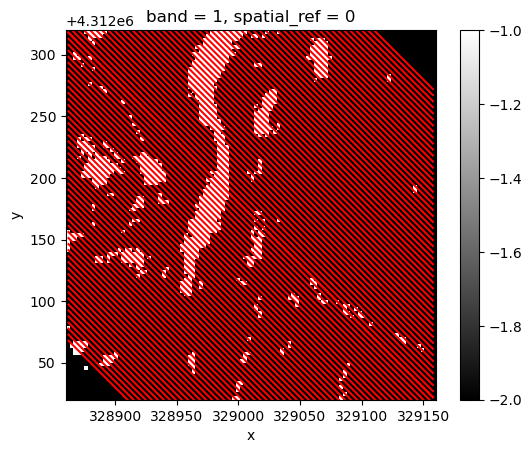

In [27]:
fig, ax = plt.subplots()
gpd.GeoDataFrame(geometry=lines).plot(color='red', ax=ax)
(~srcs[4]).plot(cmap='grey')

In [18]:
samples_list = []
segment_lengths_list_list = []
for src in srcs:
    samples = [sample_along_line(line, src) for line in lines]
    segment_lengths_list = [
        calculate_temp_segment_lengths(df, root = 0.5) for df in samples
    ]
    samples_list.append(samples)
    segment_lengths_list_list.append(segment_lengths_list)

If we wanted to REMOVE PATHS that STARTED AS SNOW, this would be how to do it:

In [38]:
print(len([s for s in samples_list[0] if ~ s['below_zero'].iloc[0]]), len(samples_list[0]))
print(len([s for s in samples_list[1] if ~ s['below_zero'].iloc[0]]), len(samples_list[1]))
print(len([s for s in samples_list[2] if ~ s['below_zero'].iloc[0]]), len(samples_list[2]))
print(len([s for s in samples_list[3] if ~ s['below_zero'].iloc[0]]), len(samples_list[3]))
print(len([s for s in samples_list[4] if ~ s['below_zero'].iloc[0]]), len(samples_list[4]))
print(len([s for s in samples_list[5] if ~ s['below_zero'].iloc[0]]), len(samples_list[5]))

1 105
4 105
21 105
93 105
100 105
105 105


(101, 105)

In [91]:
patch_df = pd.concat([
    pd.DataFrame(
        pd.Series(segment_lengths_list).rename('patch_length').explode()
    ).assign(
        date = fn.split('/')[-1][:10]
    )
    for fn,segment_lengths_list in zip(files, segment_lengths_list_list)
])

In [94]:
alt.Chart(
    patch_df
).mark_bar().encode(
    alt.X('patch_length:Q').bin(step=2),
    alt.Y('count():Q'),
    alt.Facet('date:O')
)

alt.Chart(...)

In [148]:
alt.Chart(patch_df).transform_joinaggregate(
    total='count(*)',
    groupby=['date']
).transform_calculate(
    pct='1 / datum.total'
).mark_bar(opacity=0.5).encode(
    alt.X('patch_length:Q').bin(step=5).axis(values=[0,25,50,100]).scale(domain=[0,100], clamp=True),
    alt.Y('sum(pct):Q', stack=False, axis=alt.Axis(format='%')),
    alt.Facet('date')
).properties(height=100, width=100)

alt.Chart(...)

In [151]:
alt.Chart(
    patch_df
).transform_density(
    'patch_length',
    as_=['patch_length', 'density'],
    groupby=['date'],
    bandwidth=5
).mark_line().encode(
    alt.X('patch_length:Q').scale(domain=[0,200], clamp=True),
    alt.Y('density:Q'),
).properties(height=100, width=100).facet(
        alt.Facet('date')
)

alt.FacetChart(...)

In [154]:
patch_df.to_csv('patch_lengths.csv', index=None)